# 1.Data load and data cleaning

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import re
from nltk.util import ngrams

import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
import matplotlib.dates as mdates
import missingno



In [4]:
cust_data = pd.read_csv('QVI_purchase_behaviour.csv')
trans_data = pd.read_excel('QVI_transaction_data.xlsx')

In [5]:
cust_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [6]:
cust_data.shape

(72637, 3)

In [7]:
# check null or missing values for cust_data
cust_data.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

<AxesSubplot:>

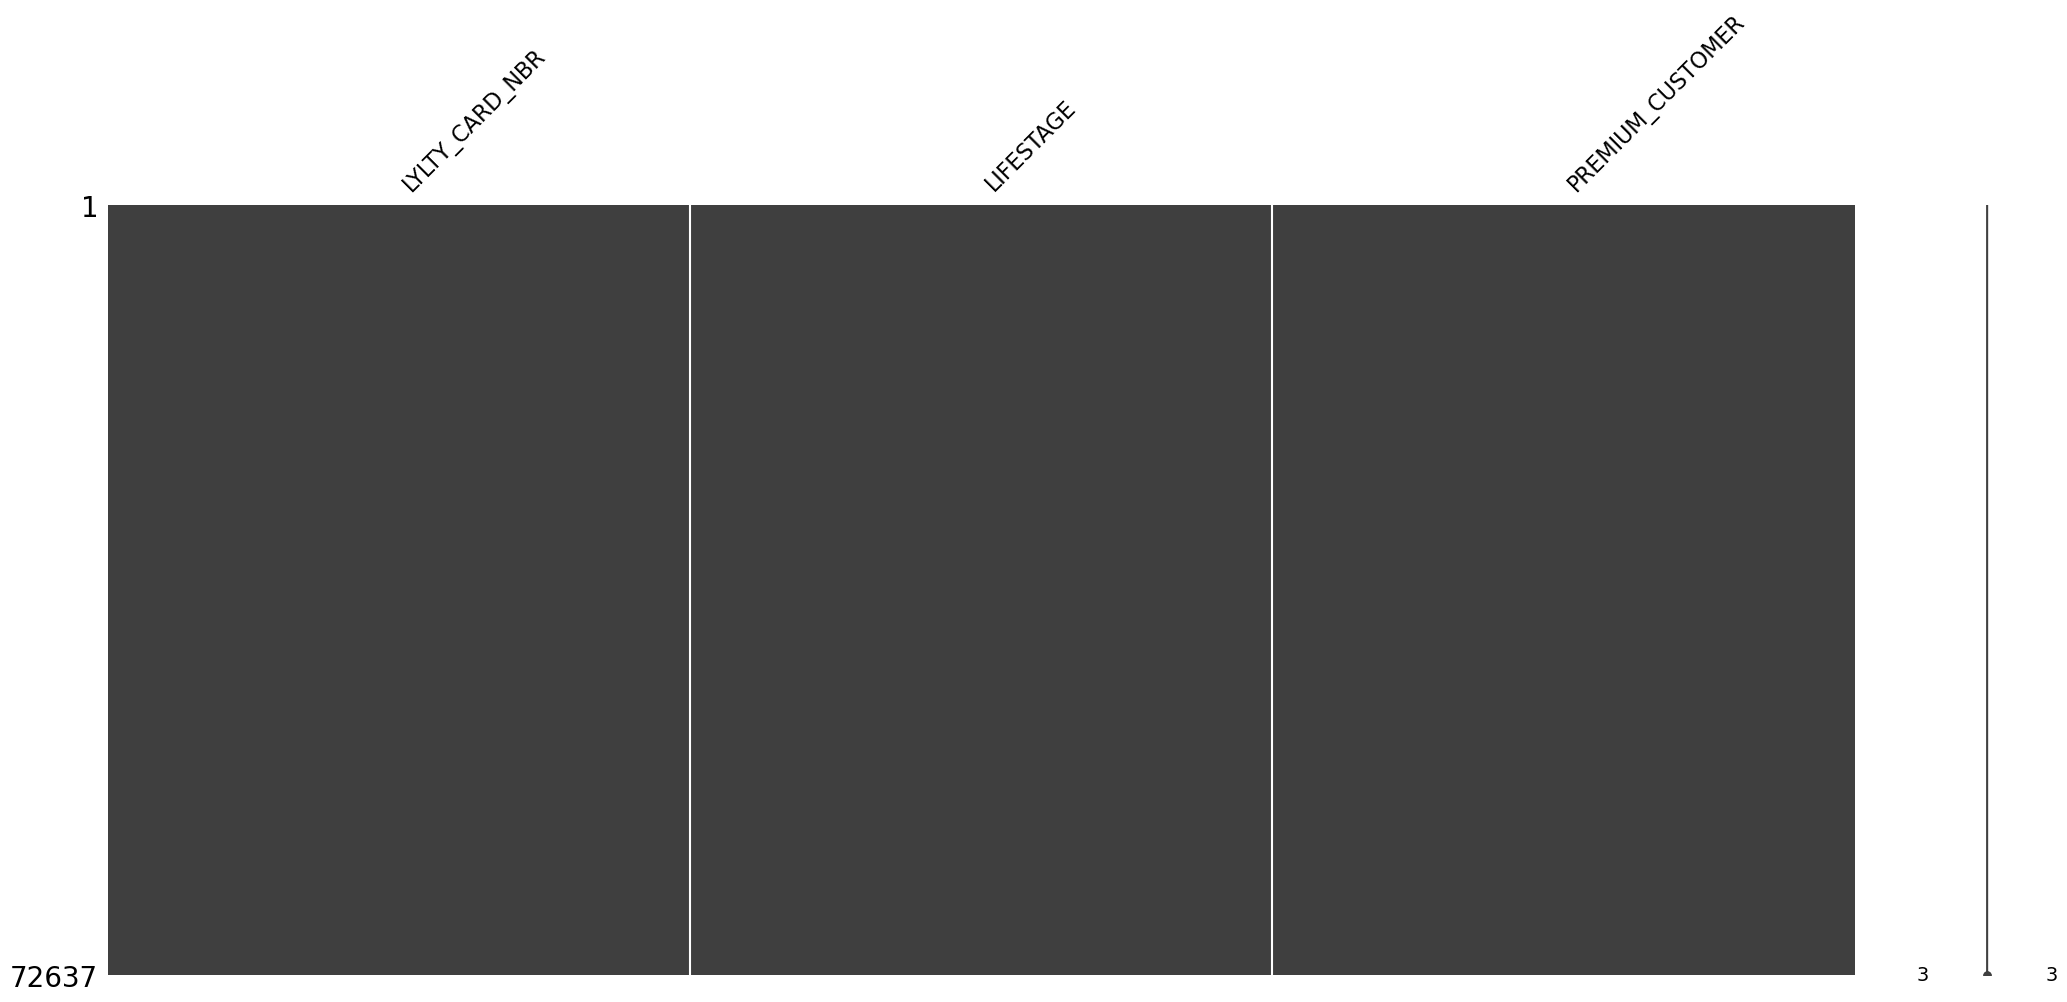

In [8]:
# looking for null values in any column for cust_data

missingno.matrix(cust_data)

In [9]:
trans_data.shape 

(264836, 8)

In [10]:
trans_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [11]:
# check null or missing values for trans_data
trans_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

<AxesSubplot:>

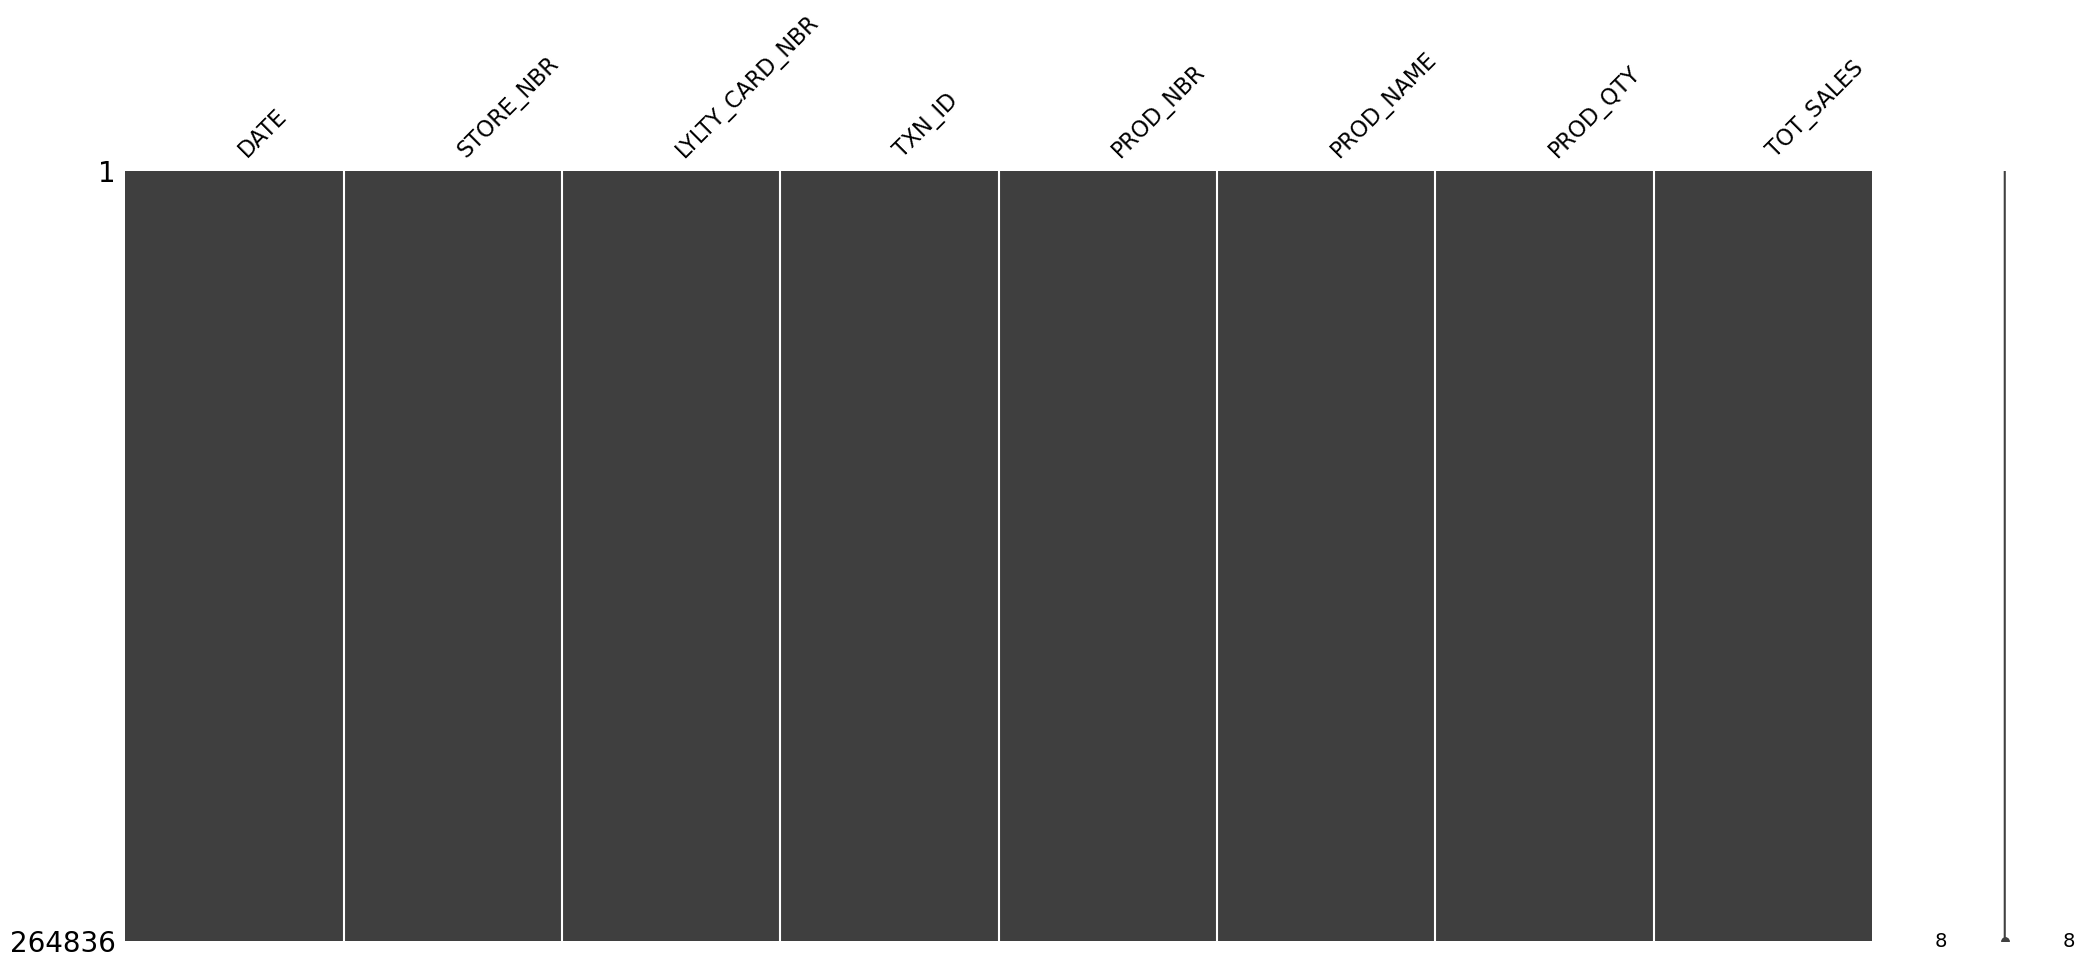

In [12]:
missingno.matrix(trans_data)

In [13]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


## Clean Date column

In [14]:
# Change date format from excel to original form
trans_data['DATE'] = pd.TimedeltaIndex(trans_data['DATE'], unit='d') + dt.datetime(1899, 12, 30)

In [15]:
trans_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


## To clean PROD_NAME column

In [16]:
# Extract size of the product (e.g 175g)

trans_data['PACK_SIZE'] = [re.search(r"[0-9]+(g|G)", p).group(0).replace('G','').replace('g','') for p in trans_data['PROD_NAME']]

In [17]:
# check unique products
trans_data['PROD_NAME'].unique()[:10]

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G'], dtype=object)

Some of the products are not chips, most of them with the word 'Salsa'. However, some salsa are actually chips with 'salsa' in their product names. We will need to remove those that are salsa and not chips.

In [18]:
# Remove salsa dips from string
trans_data = trans_data[~trans_data['PROD_NAME'].isin(['Old El Paso Salsa   Dip Tomato Mild 300g',
'Old El Paso Salsa   Dip Chnky Tom Ht300g',
'Woolworths Mild     Salsa 300g',
'Old El Paso Salsa   Dip Tomato Med 300g',
'Woolworths Medium   Salsa 300g',
'Doritos Salsa Mild  300g',
'Doritos Salsa       Medium 300g'])].reset_index(drop=True)

In [19]:
# replace & with space and remove multiple spaces
trans_data['PROD_NAME'] = [" ".join(p.replace('&',' ').split()) for p in trans_data['PROD_NAME']]
# remove digits that are followed by grams
trans_data['PROD_NAME'] = [re.sub(r"\s*[0-9]+(g|G)", r"", p) for p in trans_data['PROD_NAME']]

In [20]:
def replaceWords(string):
    # specific
    string = re.sub(r"SeaSalt", "Sea Salt", string)
    string = re.sub(r"Frch/Onin", "French Onion", string)
    string = re.sub(r"Cheddr Mstrd", "Cheddar Mustard", string)
    string = re.sub(r"Jlpno Chili", "Jalapeno Chilli", string)
    string = re.sub(r"Swt/Chlli Sr/Cream", "Sweet Chilli Sour Cream", string)
    string = re.sub(r"SourCream", "Sour Cream", string)
    string = re.sub(r"Tmato Hrb Spce", "Tomato Herb Spice", string)
    string = re.sub(r"S/Cream", "Sour Cream", string)
    string = re.sub(r"ChipsFeta", "Chips Feta", string)
    string = re.sub(r"ChpsHny", "Chips Honey", string)
    string = re.sub(r"FriedChicken", "Fried Chicken", string)
    string = re.sub(r"OnionDip", "Onion Dip", string)
    string = re.sub(r"SweetChili", "Sweet Chilli", string)
    string = re.sub(r"PotatoMix", "Potato Mix", string)
    string = re.sub(r"Seasonedchicken", "Seasoned Chicken", string)
    string = re.sub(r"CutSalt/Vinegr", "Cut Salt Vinegar", string)
    string = re.sub(r"ChpsBtroot", "Chips Beetroot", string)
    string = re.sub(r"ChipsBeetroot", "Chips Beetroot", string)
    string = re.sub(r"ChpsFeta", "Chips Feta", string)
    string = re.sub(r"OnionStacked", "Onion Stacked", string)
    string = re.sub(r"Ched", "Cheddar", string)
    string = re.sub(r"Strws", "Straws", string)
    string = re.sub(r"Slt", "Salt", string)
    string = re.sub(r"Chikn", "Chicken", string)
    string = re.sub(r"Rst", "Roast", string)
    string = re.sub(r"Vinegr", "Vinegar", string)
    string = re.sub(r"Mzzrlla", "Mozzarella", string)
    string = re.sub(r"Originl", "Original", string)
    string = re.sub(r"saltd", "Salted", string)
    string = re.sub(r"Swt", "Sweet", string)
    string = re.sub(r"Chli", "Chilli", string)
    string = re.sub(r"Hony", "Honey", string)
    string = re.sub(r"Chckn", "Chicken", string)
    string = re.sub(r"Chp", "Chip", string)
    string = re.sub(r"Btroot", "Beetroot", string)
    string = re.sub(r"Chs", "Cheese", string)
    string = re.sub(r"Crm", "Cream", string)
    string = re.sub(r"Orgnl", "Original", string)

    return string

trans_data['PROD_NAME'] = [replaceWords(s) for s in trans_data['PROD_NAME']]

trans_data['PROD_NAME'].replace('Infzns Crn Crnchers Tangy Gcamole',
'Infuzions Corn Crunchers Tangy Guacamole', inplace=True)

In [21]:
trans_data['PROD_NAME'].unique()[:10]

array(['Natural Chip Compny Sea Salt', 'CCs Nacho Cheese',
       'Smiths Crinkle Cut Chips Chicken',
       'Smiths Chip Thinly Sour Cream Onion',
       'Kettle Tortilla Chips Honey Jalapeno Chilli',
       'Smiths Crinkle Chips Salt Vinegar', 'Grain Waves Sweet Chilli',
       'Doritos Corn Chip Mexican Jalapeno',
       'Grain Waves Sour Cream Chives', 'Kettle Sensations Siracha Lime'],
      dtype=object)

## Extract Product brand

In [22]:
def replaceBrands(string):
    # specific
    string = re.sub(r"Red Rock Deli", "RRD", string)
    string = re.sub(r"Dorito", "Doritos", string)
    string = re.sub(r"Doritoss", "Doritos", string)
    string = re.sub(r"Smith", "Smiths", string)
    string = re.sub(r"Smithss", "Smiths", string)
    string = re.sub(r"GrnWves", "Grain Waves", string)
    string = re.sub(r"Woolworths", "WW", string) 
    string = re.sub(r"Snbts", "Sunbites", string) 

    return string

# standardize common brand names
trans_data['PROD_NAME'] = [replaceBrands(s) for s in trans_data['PROD_NAME']]

# get brand name from first word
trans_data['brand'] = [s.split(' ')[0] for s in trans_data['PROD_NAME']]

In [23]:
trans_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand
0,2018-10-17,1,1000,1,5,Natural Chip Compny Sea Salt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly Sour Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chips Honey Jalapeno Chilli,3,13.8,150,Kettle


## Remove outliers:

In [24]:
trans_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,249670.000000,2.496700e+05,2.496700e+05,249670.000000,249670.000000,249670.000000
mean,135.044278,1.355203e+05,1.351234e+05,56.294288,1.907762,7.293966
std,76.773591,8.065746e+04,7.813155e+04,33.528758,0.657126,3.071796
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001625e+04,6.757425e+04,27.000000,2.000000,5.700000
50%,130.000000,1.303600e+05,1.351475e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030798e+05,2.026338e+05,86.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [25]:
trans_data = trans_data[trans_data['PROD_QTY'] < 200].reset_index(drop=True)

# 2. Exploratory Data Analysis (EDA)


## By brand name

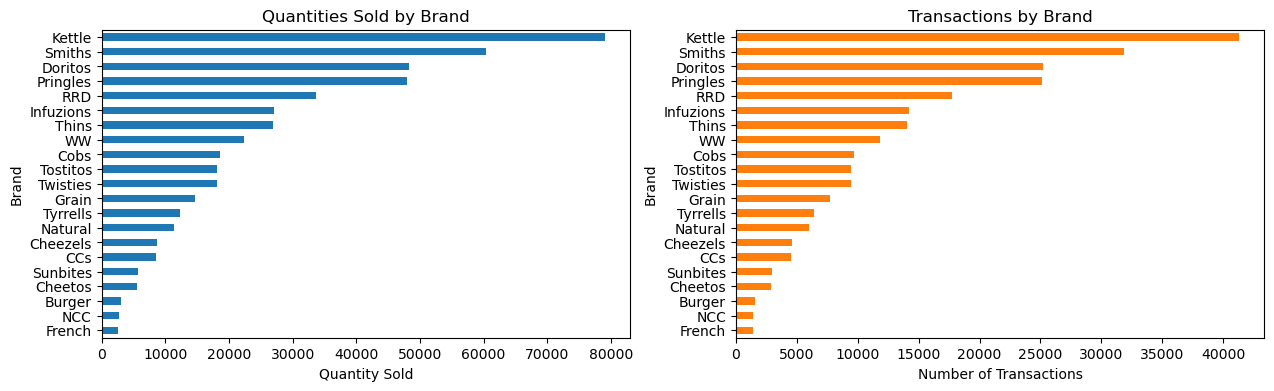

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# Product quantity sales by brand
ax1=plt.subplot(121)
trans_data.groupby(['brand'], as_index=False).agg({'PROD_QTY': 'sum'}).sort_values('PROD_QTY').plot.barh(x='brand',legend=False, ax=ax1)

ax1.set_xlabel('Quantity Sold')
ax1.set_ylabel('Brand')
ax1.set_title('Quantities Sold by Brand')

ax2=plt.subplot(122)
trans_data.groupby(['brand'], as_index=False)[['TXN_ID']].count().sort_values('TXN_ID').plot.barh(x='brand',color='#ff7f0e', legend=False, ax=ax2)
ax2.set_xlabel('Number of Transactions')
ax2.set_ylabel('Brand')
ax2.set_title('Transactions by Brand')

plt.show()

## By Date

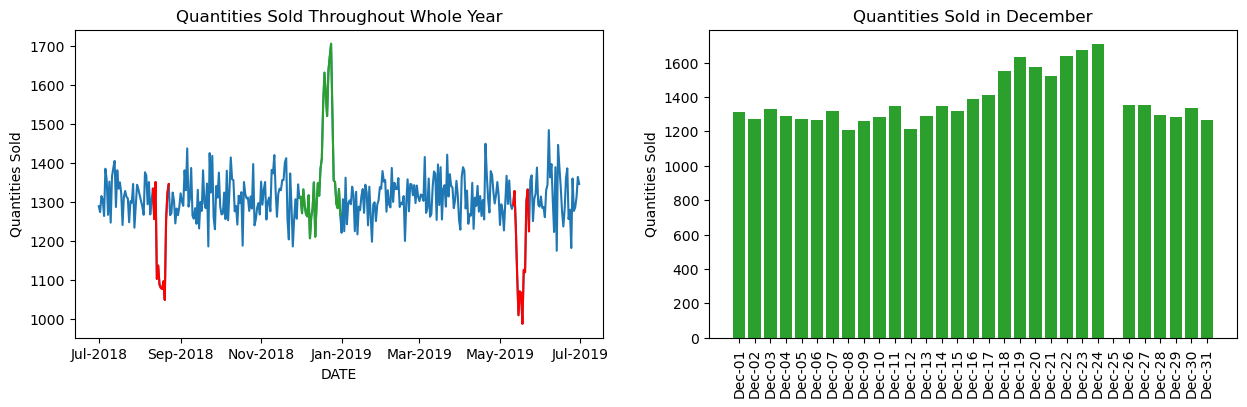

In [27]:
## Plot quantities sold by date
bydate = trans_data.groupby('DATE').agg({'PROD_QTY': 'sum'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

ax1=plt.subplot(121)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate, ax=ax1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate[(bydate['DATE'] > '2018-11-30') & (bydate['DATE'] < '2019-01-01')], color='#2ca02c', ax=ax1)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate[(bydate['DATE'] > '2018-08-10') & (bydate['DATE'] < '2018-08-24')], color='red', ax=ax1)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate[(bydate['DATE'] > '2019-05-10') & (bydate['DATE'] < '2019-05-24')], color='red', ax=ax1)
plt.ylabel('Quantities Sold')
plt.title('Quantities Sold Throughout Whole Year')


## Plot December quantities sold
# filter december
december = bydate[bydate['DATE'].isin(pd.date_range(start="2018-12-01",end="2018-12-31").tolist())]

# fill in missing dec data
december = december.set_index('DATE').reindex(pd.date_range(start="2018-12-01",end="2018-12-31"), fill_value=0)

ax2=plt.subplot(122)
ax2.bar(december.index,december['PROD_QTY'],color='#2ca02c')
ax2.set_xticks(december.index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%d"))
ax2.tick_params(axis='x', rotation=90) 
plt.ylabel('Quantities Sold')
plt.title('Quantities Sold in December')
plt.show()

## By Packet Size

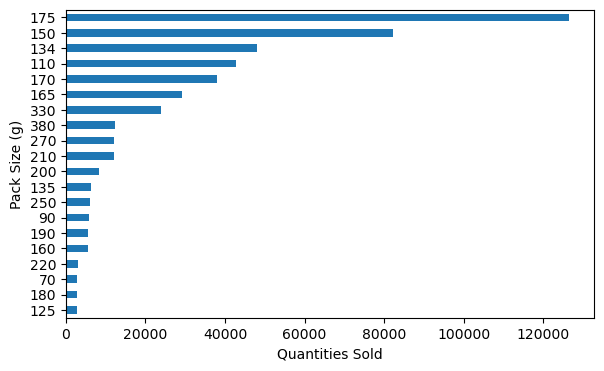

In [28]:
# Product Size

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

ax1=plt.subplot(121)
trans_data.groupby('PACK_SIZE').agg({'PROD_QTY': 'sum'}).sort_values('PROD_QTY').reset_index().plot.barh(x='PACK_SIZE', legend=False, ax=ax1)
ax1.set_ylabel('Pack Size (g)')
ax1.set_xlabel('Quantities Sold')

plt.show()

## By Product Keyword

In [29]:
# Function for counting product keywords
def count_keywords(df):
    words_freq = {}
    for c,p in enumerate(df['PROD_NAME']):
        for word in p.split():
            if word in words_freq:
                words_freq[word] += df['PROD_QTY'][c]
            else:
                words_freq[word] = df['PROD_QTY'][c]
    
    return words_freq

# Function for generating ngrams
def generate_ngrams(text, n):
    words = text.split()
    return [' '.join(ngram) for ngram in list(ngrams(words, n))]

# Function for counting product bigrams
def count_bigrams(df):
    bigrams_freq = {}
    for c,p in enumerate(df['PROD_NAME']):
        for ngram in generate_ngrams(p, 2):
            if ngram in bigrams_freq:
                bigrams_freq[ngram] += df['PROD_QTY'][c]
            else:
                bigrams_freq[ngram] = df['PROD_QTY'][c]
    return bigrams_freq

words_freq = count_keywords(trans_data)
bigrams_freq = count_bigrams(trans_data)

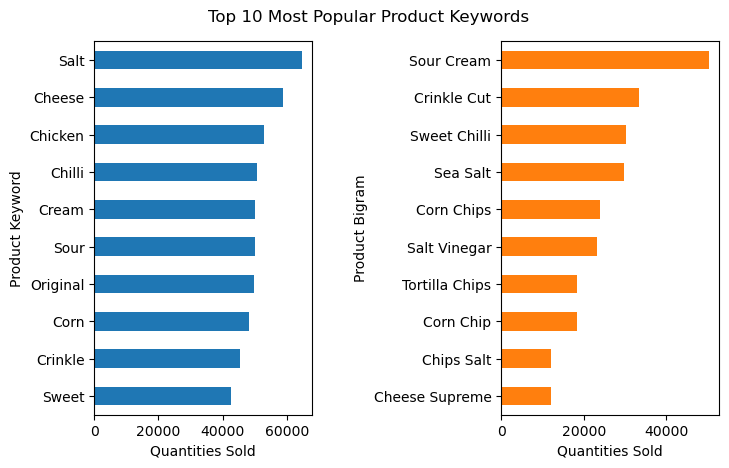

In [30]:
# get top keywords
topwords = pd.DataFrame(words_freq.items(), columns=['word','freq']).sort_values('freq')
topwords = topwords[~topwords.word.isin(['Chips','Kettle','Smiths','Doritos','Pringles'])]

# get top bigrams
topbigrams = pd.DataFrame(bigrams_freq.items(), columns=['bigram','freq']).sort_values('freq')
topbigrams = topbigrams[~topbigrams.bigram.isin(['Smiths Crinkle','Doritos Corn','Thins Chips','Cobs Popd','Kettle Tortilla','Grain Waves','Kettle Sensations','Kettle Sweet','Tyrrells Crisps','Twisties Cheese'])]

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

ax1 = plt.subplot(121)
topwords[-10:].plot.barh(x='word', legend=False, ax=ax1)
ax1.set_xlabel('Quantities Sold')
ax1.set_ylabel('Product Keyword')

ax2 = plt.subplot(122)
topbigrams[-10:].plot.barh(x='bigram', color='#ff7f0e', legend=False, ax=ax2)
ax2.set_xlabel('Quantities Sold')
ax2.set_ylabel('Product Bigram')

fig.tight_layout(pad=3.0)
plt.suptitle('Top 10 Most Popular Product Keywords')
plt.show()

In [31]:
import wordcloud

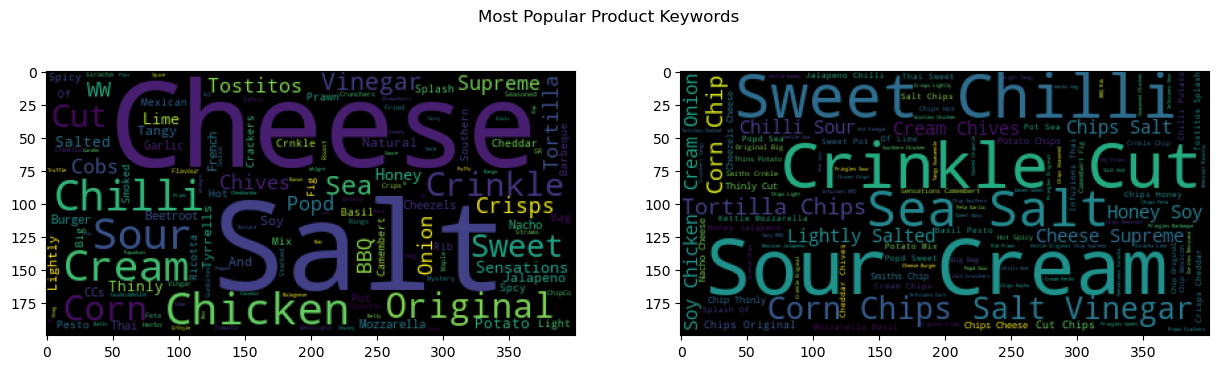

In [32]:
# Plot wordcloud of keywords and bigrams
from wordcloud import WordCloud

rem_list = ['Chips','Kettle','Smiths','Doritos','Pringles','Chip', 'Infuzions', 'RRD', 'Thins', 'Twisties', 'Grain', 'Waves']
[words_freq.pop(key) for key in rem_list] 

rem_list = ['Smiths Crinkle','Doritos Corn','Thins Chips','Cobs Popd','Kettle Tortilla','Grain Waves','Kettle Sensations','Kettle Sweet','Tyrrells Crisps','Twisties Cheese']
[bigrams_freq.pop(key) for key in rem_list] 

plt.figure(figsize=(15,4))
plt.subplot(121)
wc = WordCloud(background_color="black").generate_from_frequencies(words_freq)
plt.imshow(wc)
plt.subplot(122)
wc = WordCloud(background_color="black").generate_from_frequencies(bigrams_freq)
plt.imshow(wc)
plt.suptitle('Most Popular Product Keywords')
plt.show()

## 2.5 Customr Data

In [33]:
cust_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


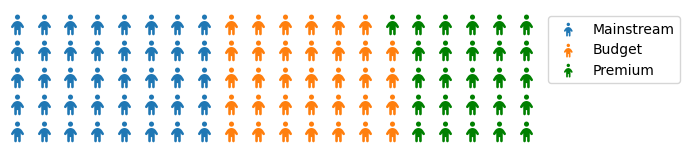

In [34]:
## Waffle chart for customer class
premium = dict(cust_data['PREMIUM_CUSTOMER'].value_counts()/len(cust_data)*100)

plt.figure(figsize=(7,5),
    FigureClass=Waffle, 
    rows=5, 
    values=premium, 
    colors=["#1f77b4", "#ff7f0e", "green"],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', 
    font_size=15, 
    icon_legend=True)
    
plt.show()

According to the waffle chart, the classes are quite evenly split, with more mainstreams followed by budget customers.

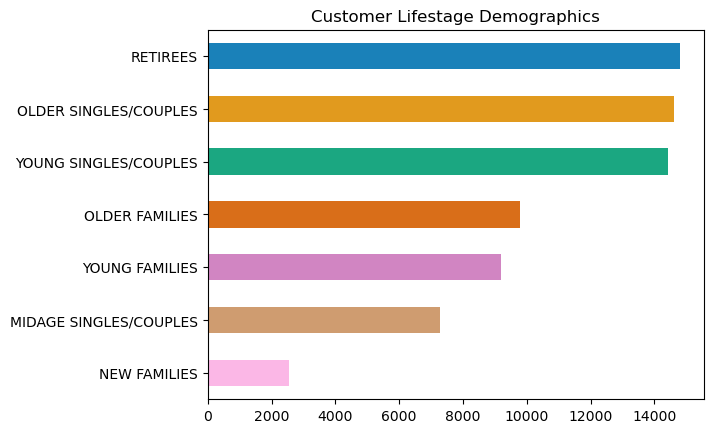

In [35]:
# Plot customer lifestage counts
cust_data.LIFESTAGE.value_counts().plot(kind='barh', alpha=.9, color=sns.color_palette("colorblind"), title='Customer Lifestage Demographics').invert_yaxis()

## 2.6 Merge Data

In [36]:
# Merge
all_data = trans_data.merge(cust_data, on='LYLTY_CARD_NBR')

print('No Duplicates:', len(all_data) == len(all_data)) # check same rows, no duplicates
print('Number of Nulls:', all_data.isnull().sum().sum()) # check for nulls

No Duplicates: True
Number of Nulls: 0


# 3. Data Analysis

In [37]:
all_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Sea Salt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips,2,3.8,160,WW,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original,1,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


## 3.1 Total Sales and Quantity

In [38]:
# Sum up for each group 
life_prem = all_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'TOT_SALES':'sum','PROD_QTY':'sum', 'TXN_ID':'count'}).reset_index().sort_values('TOT_SALES') # sort by TOT_SALES
life_prem['Group'] = life_prem['LIFESTAGE'] + '_' + life_prem['PREMIUM_CUSTOMER']

# sort by PROD_QTY
life_prem_qty = life_prem.sort_values('PROD_QTY')

In [39]:
# define Function for Lollipop chart
def loll_plot(df1,x,y,xlabel,title,firstX):
    
    my_color=np.where(df1[x]==firstX, '#ff7f0e', '#1f77b4')
    my_color[0] = 'red'
    my_size=np.where(df1[x]==firstX, 70, 30)
    my_size[0] = '70'

    plt.hlines(y=np.arange(0,len(df1)),xmin=0,xmax=df1[y],color=my_color)
    plt.scatter(df1[y], np.arange(0,len(df1)), color=my_color, s=my_size)
    plt.yticks(np.arange(0,len(df1)), df1[x])
    plt.xlabel(xlabel)
    plt.title(title)

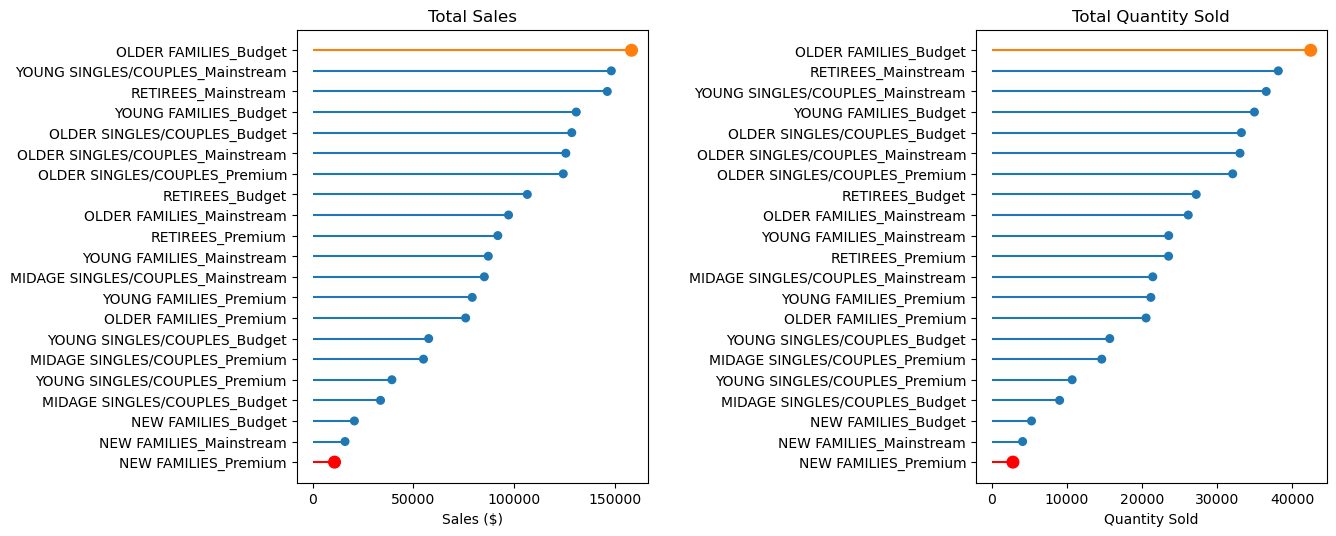

In [40]:
## Sales and Quantity Sold by each Segment
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
loll_plot(life_prem,'Group','TOT_SALES','Sales ($)','Total Sales','OLDER FAMILIES_Budget')
plt.xticks(ticks=[0,50000,100000,150000])

ax2 = plt.subplot(122)
loll_plot(life_prem_qty,'Group','PROD_QTY','Quantity Sold','Total Quantity Sold','OLDER FAMILIES_Budget')

fig.tight_layout(pad=3.0)
plt.show()

## 3.2. Total Sales Per Customer and Per Unique Customer

In [41]:
# Get number of unique customers in each group
life_prem_pc = all_data[['LYLTY_CARD_NBR','LIFESTAGE','PREMIUM_CUSTOMER']].drop_duplicates('LYLTY_CARD_NBR').reset_index(drop=True).groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).size().reset_index(name='Count').sort_values('Count').merge(life_prem, on=['LIFESTAGE','PREMIUM_CUSTOMER'])

life_prem_pc['SALES_PER_C'] = life_prem_pc['TOT_SALES']/life_prem_pc['TXN_ID']
life_prem_pc['SALES_PER_UC'] = life_prem_pc['TOT_SALES']/life_prem_pc['Count']
life_prem_pc = life_prem_pc.sort_values('SALES_PER_C')

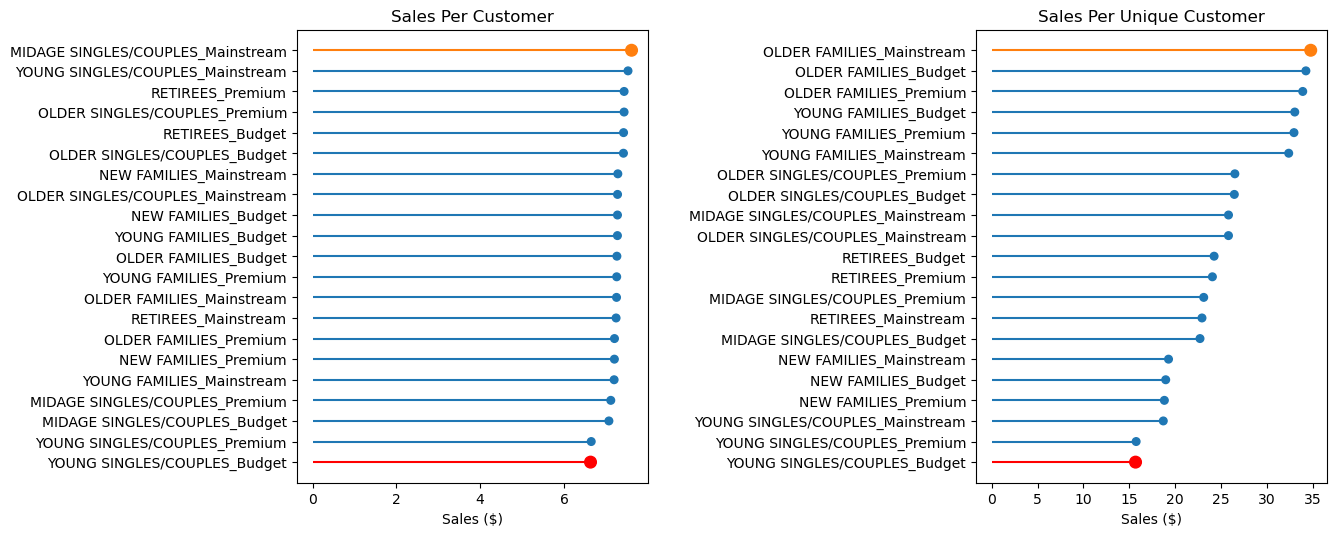

In [42]:
## Sales by each Segment per Customer and per Unique Customer
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
loll_plot(life_prem_pc,'Group','SALES_PER_C','Sales ($)','Sales Per Customer','MIDAGE SINGLES/COUPLES_Mainstream')

life_prem_pc = life_prem_pc.sort_values('SALES_PER_UC')
ax2 = plt.subplot(122)
loll_plot(life_prem_pc,'Group','SALES_PER_UC','Sales ($)','Sales Per Unique Customer','OLDER FAMILIES_Mainstream')

fig.tight_layout(pad=3.0)
plt.show()

## 3.3. Total Quantity Purchased Per Customer and Per Unique Customer

In [43]:
life_prem_pc['QTY_PER_C'] = life_prem_pc['PROD_QTY']/life_prem_pc['TXN_ID']
life_prem_pc['QTY_PER_UC'] = life_prem_pc['PROD_QTY']/life_prem_pc['Count']
life_prem_pc = life_prem_pc.sort_values('QTY_PER_C')

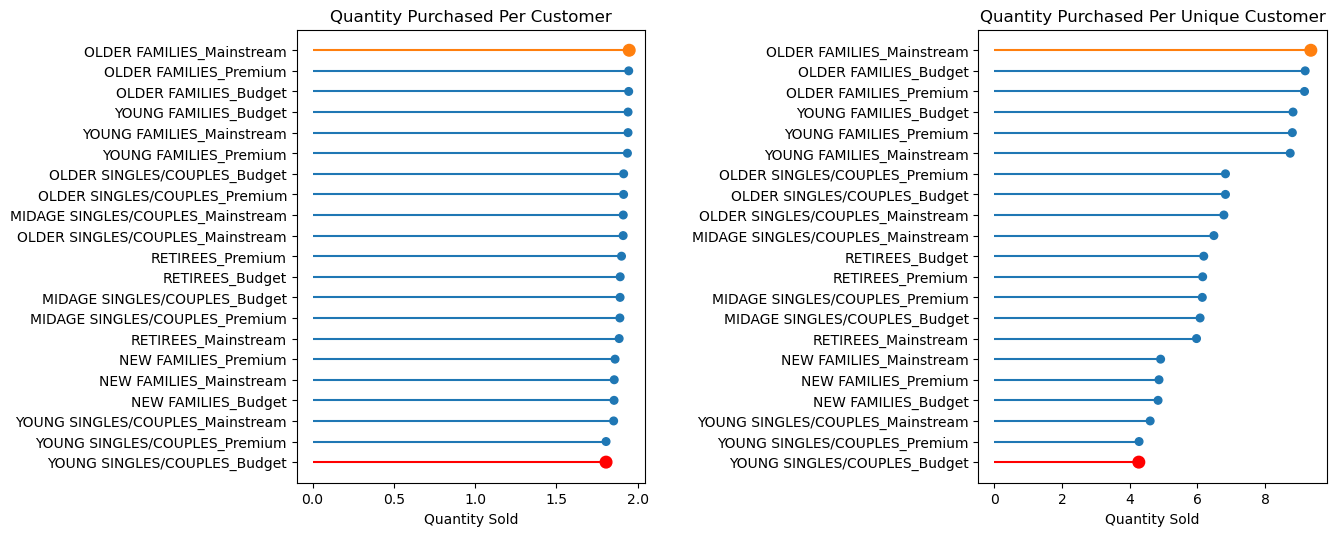

In [44]:
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
loll_plot(life_prem_pc,'Group','QTY_PER_C','Quantity Sold','Quantity Purchased Per Customer','OLDER FAMILIES_Mainstream')

life_prem_pc = life_prem_pc.sort_values('QTY_PER_UC')
ax2 = plt.subplot(122)
loll_plot(life_prem_pc,'Group','QTY_PER_UC','Quantity Sold','Quantity Purchased Per Unique Customer','OLDER FAMILIES_Mainstream')

fig.tight_layout(pad=3.0)
plt.show()

## 3.4. Number of Unique Customers in Each Segment

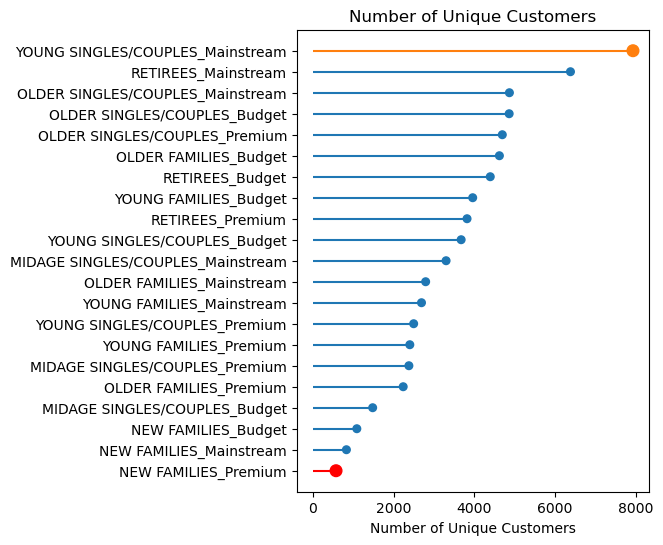

In [45]:
life_prem_pc = life_prem_pc.sort_values('Count')
fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
loll_plot(life_prem_pc,'Group','Count','Number of Unique Customers','Number of Unique Customers','YOUNG SINGLES/COUPLES_Mainstream')

## 3.5. Price Paid Per Quantity Per Unique Customer

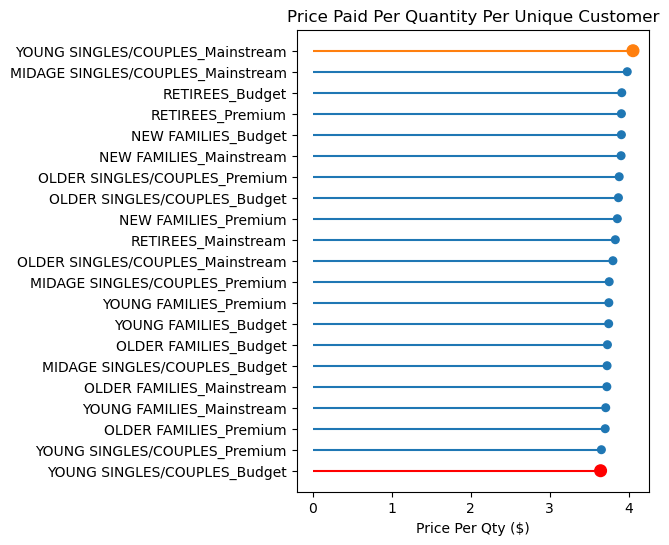

In [46]:
all_data['PRICE_PER_UNIT'] = all_data['TOT_SALES']/all_data['PROD_QTY'] # get price per unit
# get price per unit of each customer then groupby lifestage and premium_customer to get average per group
price_per_unit = all_data.groupby('LYLTY_CARD_NBR').agg({'PRICE_PER_UNIT':'mean'}).reset_index().merge(all_data[['LYLTY_CARD_NBR','LIFESTAGE','PREMIUM_CUSTOMER']], on='LYLTY_CARD_NBR').groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'PRICE_PER_UNIT':'mean'}).reset_index().sort_values('PRICE_PER_UNIT')
price_per_unit['Group'] = price_per_unit['LIFESTAGE'] + '_' + price_per_unit['PREMIUM_CUSTOMER']


fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
loll_plot(price_per_unit,'Group','PRICE_PER_UNIT','Price Per Qty ($)','Price Paid Per Quantity Per Unique Customer','YOUNG SINGLES/COUPLES_Mainstream')
